## Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

## Setup

In [3]:
seed = 100

In [4]:
headers = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df_full = pd.read_csv('../data/raw/newsCorpora.csv', sep='\t', header=None, names=headers)

In [5]:
df_full.shape

(422419, 8)

In [6]:
df = df_full.sample(10000)

In [7]:
df.sample(3)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
36304,36305,Teen sci-fi franchise 'Divergent' debuts with ...,http://www.wboc.com/story/25049514/teen-sci-fi...,WBOC TV 16,e,d_oUk702ysXcmLMXRJe0R-XgNycCM,www.wboc.com,1395624055416
399388,399907,More proof that climate change is ruining seaf...,http://www.salon.com/2014/07/30/more_proof_tha...,Salon,t,d7DNvbWMjAsHiPMdJnHjqhaDvMVPM,www.salon.com,1406726942131
21292,21293,Stocks: Investors hope for more gains,http://www.kspr.com/life/money/Stocks-Investor...,KSPR,b,dr_9dz3HbXAbfbMbFMCvyN2YZQsjM,www.kspr.com,1395231461107


## EDA

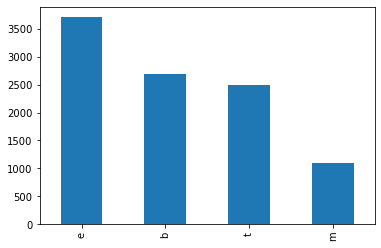

In [8]:
df['CATEGORY'].value_counts().plot(kind='bar')

Categories are reasonably well-balanced, so balancing techniques are skipped.

## Model

In [9]:
pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(random_state=100))
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__loss': ['log', 'hinge', 'modified_huber'],
    'clf__penalty': ['l1','l2','elasticnet'], 
    'clf__alpha': [1e-3, 1e-2, 1e-1, 1e0],
    'clf__shuffle': [True],
    'clf__max_iter': [500, 1000, 2000],
}

In [10]:
X = df["TITLE"]
y = df["CATEGORY"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [11]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, scoring='accuracy')
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        SGDClassifier(random_state=100))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.001, 0.01, 0.1, 1.0],
                         'clf__loss': ['log', 'hinge', 'modified_huber'],
                         'clf__max_iter': [500, 1000, 2000],
                         'clf__penalty': ['l1', 'l2', 'elasticnet'],
                         'clf__shuffle': [True],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [15]:
print(f"Best score: {search.best_score_}")
print(f"Best params: {search.best_params_}")

Best score: 0.8570666666666668
Best params: {'clf__alpha': 0.001, 'clf__loss': 'modified_huber', 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__shuffle': True, 'tfidf__ngram_range': (1, 1)}


In [16]:
y_pred = search.predict(X_test)
print(f"Accuracy on test set: {accuracy_score(y_test, y_pred)}")

Accuracy on test set: 0.8572


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           b       0.84      0.86      0.85       676
           e       0.84      0.97      0.90       927
           m       0.92      0.64      0.75       272
           t       0.88      0.79      0.83       625

    accuracy                           0.86      2500
   macro avg       0.87      0.81      0.83      2500
weighted avg       0.86      0.86      0.85      2500



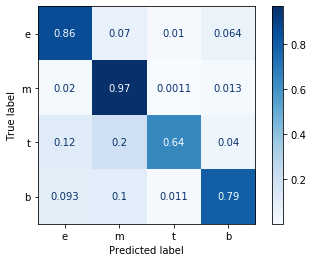

In [25]:
plot_confusion_matrix(search, X_test, y_test,
                                 display_labels=y.unique(),
                                 cmap=plt.cm.Blues,
                                 normalize='true');